In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import sobel_h,sobel_v,gaussian

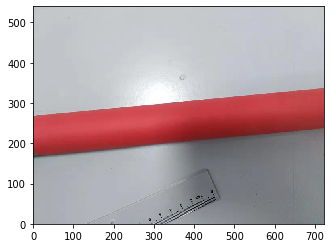

In [2]:
img_raw = plt.imread("data/3.jpg")
img_raw = img_raw[::2,::2]
h, w = np.shape(img_raw)[:2]
plt.imshow(img_raw, extent=(0,w,0,h))

c:\users\keli\onedrive\develop\_libs\pyenvs\sci\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  """Entry point for launching an IPython kernel.


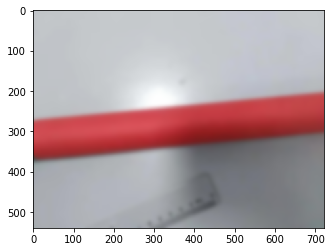

In [3]:
img_blur = gaussian(img_raw,5)
plt.imshow(img_blur)

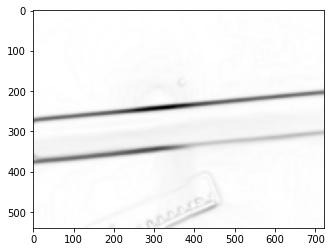

In [4]:
def sobel(img):
    components = []
    for c in range(np.shape(img)[-1]):
        components.append(sobel_h(img[:,:,c]))
        components.append(sobel_v(img[:,:,c]))
    components = np.array(components)
    edge = np.sqrt(np.sum(np.square(components),0))
    return edge

edges = sobel(img_blur)
plt.imshow(edges,cmap='Greys')

(0, 540)

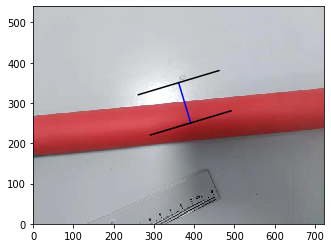

In [5]:
def plot_ruler(p1,p2):
    x1,y1 = p1
    x2,y2 = p2
    plt.plot((x1+0.5,x2+0.5),(y1+0.5,y2+0.5),color='blue')
    
    y11 = y1-(x2-x1)
    y12 = y1+(x2-x1)
    x11 = x1+(y2-y1)
    x12 = x1-(y2-y1)
    plt.plot((x11+0.5,x12+0.5),(y11+0.5,y12+0.5),color='black')
    
    y21 = y2-(x2-x1)
    y22 = y2+(x2-x1)
    x21 = x2+(y2-y1)
    x22 = x2-(y2-y1)
    plt.plot((x21+0.5,x22+0.5),(y21+0.5,y22+0.5),color='black')

p1 = np.array([w//2, h//2+80],np.float) 
p2 = np.array([w//2+30, h//2-20],np.float)
plt.imshow(img_raw, extent=(0,w,0,h))
plot_ruler(p1,p2)
plt.xlim(0,w)
plt.ylim(0,h)

In [6]:
ps = np.stack(np.meshgrid(np.arange(w),np.flip(np.arange(h))),-1)

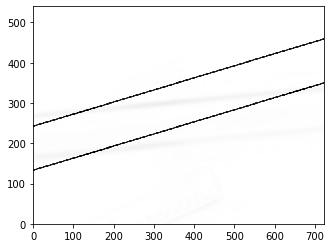

In [7]:
def lines_mask(p1,p2,ps,thickness=5):
    n = p2-p1
    n = n/np.sqrt(np.sum(np.square(n),-1))
    
    d1 = np.abs(np.sum((ps-p1)*n,-1))
    d2 = np.abs(np.sum((ps-p2)*n,-1))
    
    line1 = np.clip(thickness/2-d1,0.0,1.0)
    line2 = np.clip(thickness/2-d2,0.0,1.0)
    
    return line1, line2

line1, line2 = lines_mask(p1,p2,ps,thickness=5)
plt.imshow(line1+line2+edges, extent=(0,w,0,h),cmap="Greys")


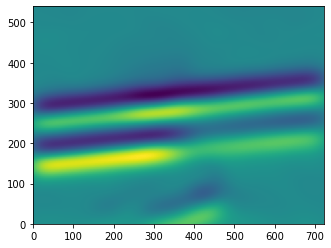

In [8]:
edges_blur = gaussian(edges,25)
grad = np.stack([sobel_v(edges_blur),-sobel_h(edges_blur)],-1)

plt.imshow(grad[...,1], extent=(0,w,0,h))

In [9]:
def compute_pan(grad,mask):
    mask = np.expand_dims(mask,-1)
    pan = np.sum(grad * mask,(0,1))
    return pan
    
mask = np.any([line1,line2],0)
compute_pan(grad,mask)

array([ 0.11735954, -0.55505705])

In [10]:
def compute_rot(pc,ps,grad,mask):
    pd = ps-pc
    rot = np.cross(grad,pd)
    # plt.imshow(rot,extent=(0,w,0,h))
    rot = np.sum(rot*mask,(0,1))
    return rot

compute_rot((p1+p2)/2,ps,grad,mask)

53.19537669066661

In [11]:
def dp_by_rot(p,rot):
    rm = np.array([
        [np.cos(rot),-np.sin(rot)],
        [np.sin(rot),np.cos(rot)]
    ])
    return np.dot(p,rm) - p

In [12]:
def compute_spring(p1,p2,lower=None,upper=None,rebound=0.0):
    if upper is None:
        upper = lower
    
    l = np.sqrt(np.sum(np.square(p1-p2)))
    if lower is not None:
        dl_lower = lower - l
        if dl_lower > 0:
            dp1 = (p1-p2) * (dl_lower+rebound)
            dp2 = -dp1
            return dp1, dp2
    elif upper is not None:
        dl_upper = l - upper
        if dl_upper > 0:
            dp1 = (p2-p1) * (dl_upper+rebound)
            dp2 = -dp1
            return dp1, dp2
    return np.zeros(2,np.float), np.zeros(2,np.float)

In [13]:
def compute_score(mask,edges):
    score = np.mean(mask * edges)
    return score

(0, 540)

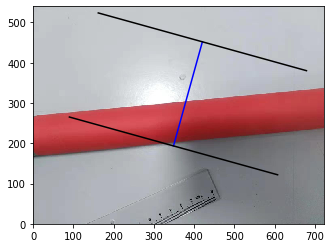

In [14]:
h, w = np.shape(edges)
p1 = np.array([w//2, h//2+50],np.float)+np.random.normal(0,60,2)
p2 = np.array([w//2, h//2-50],np.float)+np.random.normal(0,60,2)

v1 = np.zeros(2,np.float)
v2 = np.zeros(2,np.float)

scores = []
movements = []

plt.imshow(img_raw, extent=(0,w,0,h))
plot_ruler(p1,p2)
plt.xlim(0,w)
plt.ylim(0,h)

step=1, movement=1.18, score=1.19
step=2, movement=2.01, score=1.20
step=3, movement=2.63, score=1.20
step=4, movement=3.12, score=1.21
step=5, movement=3.58, score=1.21
step=6, movement=4.04, score=1.22
step=7, movement=4.45, score=1.24
step=8, movement=4.72, score=1.25
step=9, movement=4.73, score=1.27
step=10, movement=4.46, score=1.29
step=11, movement=4.11, score=1.31
step=12, movement=3.98, score=1.32
step=13, movement=4.12, score=1.34
step=14, movement=4.34, score=1.35
step=15, movement=4.43, score=1.37
step=16, movement=4.31, score=1.39
step=17, movement=3.99, score=1.40
step=18, movement=3.60, score=1.42
step=19, movement=3.26, score=1.43
step=20, movement=3.03, score=1.44
step=21, movement=2.92, score=1.46
step=22, movement=2.95, score=1.47
step=23, movement=3.05, score=1.48
step=24, movement=3.15, score=1.50
step=25, movement=3.22, score=1.51
step=26, movement=3.26, score=1.52
step=27, movement=3.29, score=1.53
step=28, movement=3.32, score=1.55
step=29, movement=3.36, score

(0, 540)

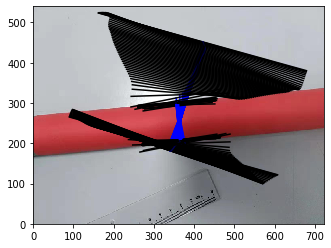

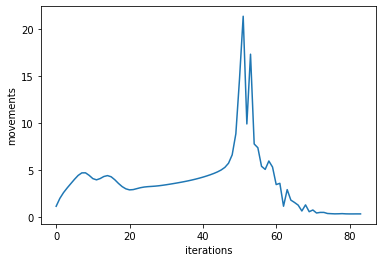

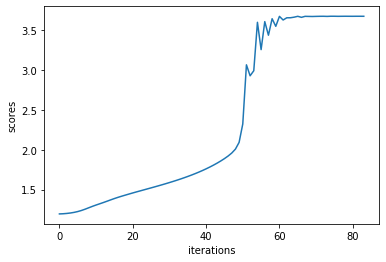

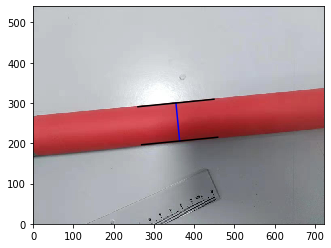

In [15]:
plt.imshow(img_raw, extent=(0,w,0,h))
plt.xlim(0,w)
plt.ylim(0,h)

decent_rate = 1
momentum = 1
damping = 0.3

length = np.sqrt(w*h)
thickness = 5

pan_m = 0.0001*length*thickness
rot_m = 0.002*length*length*thickness
spr_m = 0.1*length

plot_ruler(p1,p2)

mask1, mask2 = lines_mask(p1,p2,ps,thickness)
mask_all = mask1+mask2

for i in range(100):
    mask1, mask2 = lines_mask(p1,p2,ps,thickness)
    mask_all = mask1+mask2
    
    pc = (p1+p2)/2
    
    dp1 = 0
    dp2 = 0
    
    pan1 = compute_pan(grad,mask1) / pan_m
    pan2 = compute_pan(grad,mask2) / pan_m
    # print(pan1,pan2)
    dp1 += pan1
    dp2 += pan2
    
    rot = compute_rot(pc,ps,grad,mask_all) / rot_m
    dp1 += dp_by_rot(p1-pc,rot)
    dp2 += dp_by_rot(p2-pc,rot)
    # print(dp_by_rot(p1-pc,rot),dp_by_rot(p2-pc,rot))

    spring1, spring2 = compute_spring(p1,p2,50,150,10)
    dp1 += spring1 / spr_m
    dp2 += spring2 / spr_m
    # print(spring1 / spr_m,spring2 / spr_m)
    
    # print(dp1,dp2)
    
    # v1 = dp1*decent_rate/momentum
    # v2 = dp2*decent_rate/momentum
    
    v1 += dp1*decent_rate/momentum
    v2 += dp2*decent_rate/momentum
    
    v1 *= 1.0-damping
    v2 *= 1.0-damping
    
    p1 += v1
    p2 += v2
    
    movement = np.sqrt(np.sum(np.square(v1))) + np.sqrt(np.sum(np.square(v2)))
    movements.append(movement)
    
    score = compute_score(mask_all,edges_blur)*(10**4)
    # score = compute_score(mask_all,edges)
    scores.append(score)
    
    print(f"step={len(movements)}, movement={movement:.2f}, score={score:.2f}")
    plot_ruler(p1,p2)
    
    if len(movements)>5:
        if movements[-1]<0.5:
            last_movements = np.array(movements[-5:])
            mean = np.mean(last_movements)
            std_dev = np.sqrt(np.mean(np.square(last_movements-mean)))
            if std_dev/mean <= 0.01:
                break

plt.figure()
plt.plot(movements)
plt.ylabel("movements")
plt.xlabel("iterations")

plt.figure()
plt.plot(scores)
plt.ylabel("scores")
plt.xlabel("iterations")

plt.figure()
plt.imshow(img_raw, extent=(0,w,0,h))
plot_ruler(p1,p2)
plt.xlim(0,w)
plt.ylim(0,h)